# Тестирование алгоритмов

### Импортируются необходимые библиотеки

In [97]:
# Рисовать графики сразу 
%matplotlib inline 

# необходимые либы 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import time

# Для виджетов 
from IPython.display import display, clear_output
from ipywidgets import DatePicker, Checkbox, ToggleButton, HBox

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

In [99]:
# Объединяем колонки INTERVAL иM_DATE
def date_time_parser(d, t): 
    date = dt.datetime.strptime(d, '%d.%m.%Y %H:%M:%S')
    try: 
        hour = int(t)
    except ValueError:
        hour = 0
    finally:
        time = dt.time(hour)
    return dt.datetime.combine(date, time)
    
df = pd.read_csv('data/Генерация и потребление_01.12.2019-27.11.2020.csv',
                 sep=';', parse_dates={'DATE_TIME':['M_DATE', "INTERVAL"]}, 
                 date_parser=date_time_parser)
# Удалим неопределенные? зоны 
df = df[df['POWER_SYS_ID'] != 0]

In [100]:
# Удаляются строки без данных
data_filtered = df[df.GEN_FACT > 0]

In [109]:
# Определяем от и до 
date_from = dt.datetime(2014, 11, 1, 0, 0)
date_to = dt.datetime(2020, 11, 27, 0, 0)

dpicker_from = DatePicker(
    description='От:',
    value = date_from
)
dpicker_to = DatePicker(
    description='До:',
    value=date_to
)

def time_2_datetime(t):
    return dt.datetime.combine(t, dt.datetime.min.time())

def on_from_button_clicked(b):
    global date_from
    date_from = time_2_datetime(b['new'])

def on_to_button_clicked(b):
    global date_to
    date_to = time_2_datetime(b['new'])

dpicker_from.observe(on_from_button_clicked, names='value')
dpicker_to.observe(on_to_button_clicked, names='value')

HBox([dpicker_from, dpicker_to])

In [110]:
first_zone = True 
second_zone = True 

first_cb = Checkbox(
    description="1 ценовая зона",
    value=first_zone)

second_cb = Checkbox(
    description="2 ценовая зона",
    value=second_zone)

def on_first_clicked(cb):
    global first_zone
    first_zone = cb.new
    print("First zone ", first_zone)
    
def on_second_clicked(cb): 
    global second_zone
    second_zone = cb.new
    print("Second zone ", second_zone)
    
first_cb.observe(on_first_clicked, names='value')
second_cb.observe(on_second_clicked, names='value')

HBox([first_cb, second_cb])

Second zone  False
Second zone  True


In [111]:
sys_list = df['POWER_SYS_ID'].unique()

# инициализируем выбранные 
sys_checked = dict((sys, True) for sys in sys_list)

# создаём кнопочки 
sys_cbs = [] 
for sys in sys_list: 
    def handler(local_sys): 
        def wrap(cb):
            global sys_checked
            sys_checked[local_sys] = cb.new 
            print(f"ОЭС {local_sys} {cb.new}")
        return wrap
    
    cb = Checkbox(
        description=str(sys),
        value = sys_checked[sys],
        )
    cb.observe(handler(sys), names='value')
    sys_cbs.append(cb)
    
HBox(sys_cbs)

ОЭС 550000 False
ОЭС 600000 False
ОЭС 610000 False
ОЭС 630000 False
ОЭС 840000 False


In [112]:
# Список графиков 
graphs = ('E_USE_FACT','E_USE_PLAN', 'GEN_FACT', 'GEN_PLAN')
# инициализируем выбранные графики 
graph_checked = dict((gr, True) for gr in graphs)

# создаём кнопочки 
graph_cbs = [] 
for graph in graphs: 
    def handler(local_graph): 
        def wrap(cb):
            global graph_checked
            graph_checked[local_graph] = cb.new 
            print(f"График {local_graph} {cb.new}")
        return wrap
    
    cb = Checkbox(
        description=str(graph),
        value = graph_checked[graph],
        )
    cb.observe(handler(graph), names='value')
    graph_cbs.append(cb)
    
HBox(graph_cbs)

График E_USE_PLAN False
График GEN_FACT False
График GEN_PLAN False
График E_USE_PLAN True
График GEN_FACT True
График GEN_PLAN True


ToggleButton(value=False, description='Show')

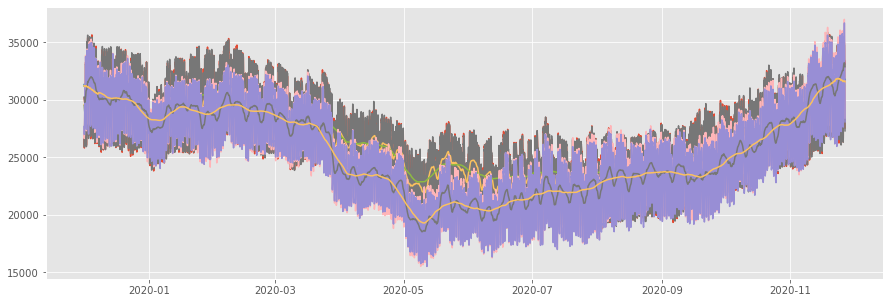

In [130]:
def running_mean(y: np.ndarray, window: int) -> np.ndarray:
    # Сглаживание скользящим средним
    yc = np.pad(y, window, mode='symmetric')
    yy = y.copy()
    for wi in range(window, len(y) + window):
        yy[wi - window] = np.nanmean(yc[wi - window: wi + window])

    return yy

# фильтруем по датам 
def filter_by_date(data_frame): 
    global date_from, date_to
    return (date_from <= data_frame['DATE_TIME']) & (data_frame['DATE_TIME'] <= date_to)
    

# фильтруем по зонам 
def filter_by_zones(data_frame): 
    global first_zone, second_zone
    
    zone_filter = np.zeros(data_frame.shape[0], dtype=bool)
    for zone_checked, zone_value in [(first_zone, 1), (second_zone, 2)]:
        if zone_checked:
            zone_filter |= (data_frame['PRICE_ZONE_ID'] == zone_value)
    return zone_filter

# фильтруем по ОЭС
def filter_by_sys(data_frame):
    global sys_checked

    sys_filter = np.zeros(data_frame.shape[0], dtype=bool)
    for sys, checked in sys_checked.items():
        if checked: 
            sys_filter |= (data_frame["POWER_SYS_ID"] == sys)
    return sys_filter 


tb = ToggleButton(
    value=False,
    description='Show'
    )

def on_show(state):
    global df 
    global graphs, graph_checked
    
    # очищаем экран 
    clear_output(wait=True)
    display(tb)
    # фильтруем данные 
    filtered = df[filter_by_date(df) & filter_by_zones(df) & filter_by_sys(df)]
    
    # выводим на экран
    for sys_key in filtered['POWER_SYS_ID'].unique():
        sys_df = filtered[filtered['POWER_SYS_ID'] == sys_key]
        for power_key in graphs:
            if graph_checked[power_key]:
                plt.plot(sys_df['DATE_TIME'], sys_df[power_key], label='{0}'.format(power_key))
                plt.plot(sys_df['DATE_TIME'], running_mean(sys_df[power_key].values, 24), label='{0} по суткам'.format(power_key))
                plt.plot(sys_df['DATE_TIME'], running_mean(sys_df[power_key].values, 24 * 7), label='{0} по неделям'.format(power_key))
tb.observe(on_show, names='value')
on_show({})

In [128]:
filtered = df[filter_by_date(df) & filter_by_zones(df) & filter_by_sys(df)]
sys_df = filtered[filtered['POWER_SYS_ID'] == 530000]
sys_df['E_USE_FACT'].values

array([26959, 26288, 25985, ..., 30018, 28364, 27552], dtype=int64)

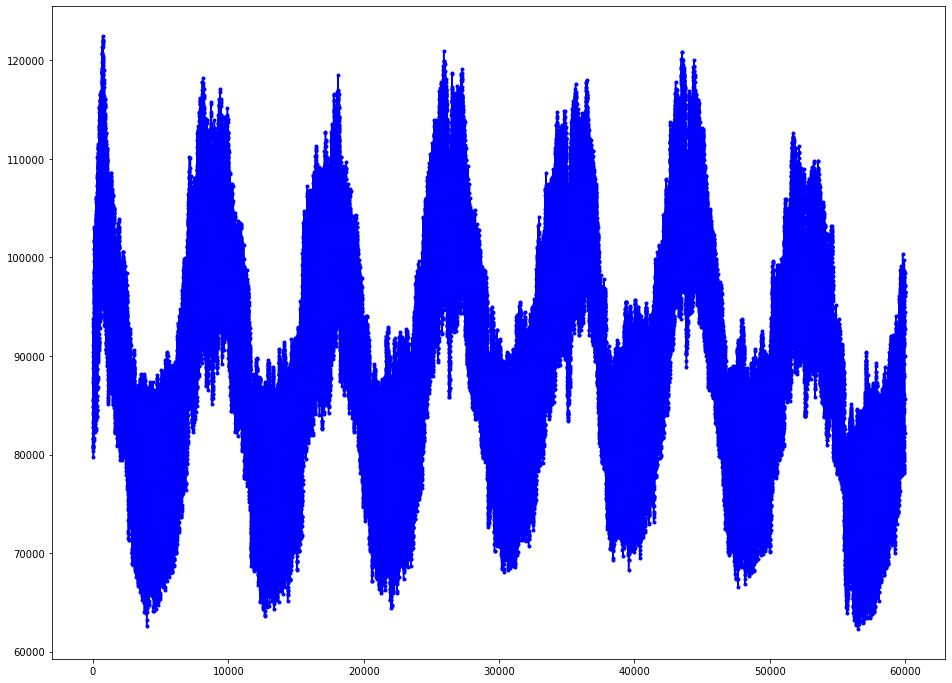

In [68]:
# Вырезается кусок отфильтрованных данных
piece = data_filtered[data_filtered.index < 24 * 7 * 51 * 7]
piece.head(30)
plt.plot(piece.GEN_FACT, 'b.-')

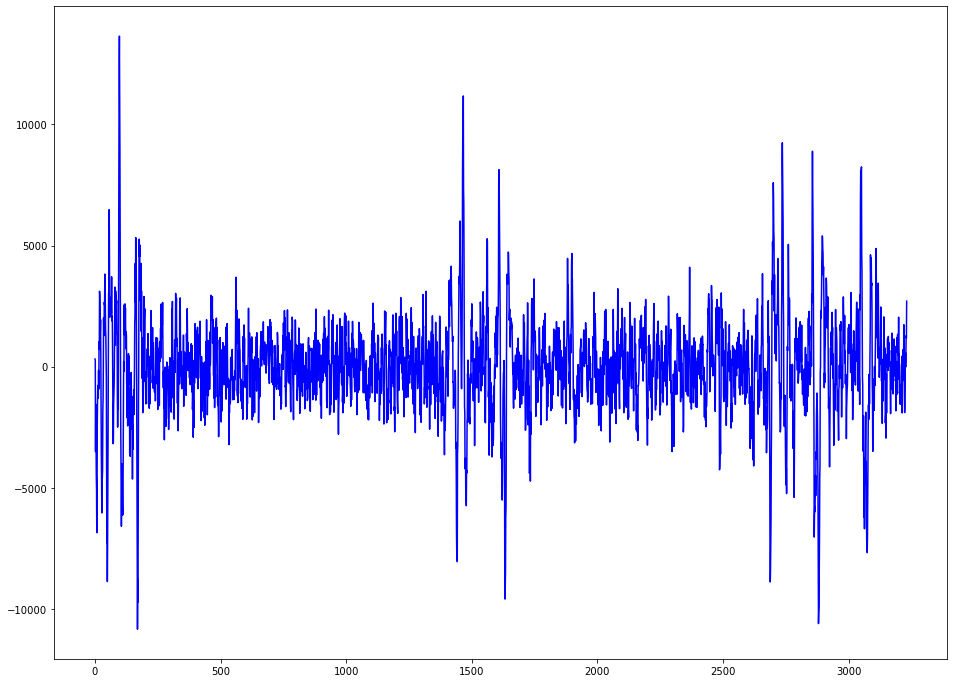

In [69]:
# Смотрим только 1 ряд - фактическую выработку
gen_fact = piece.GEN_FACT.values
# Убрана дневная сезонность
d_gen_fact = gen_fact[24:] - gen_fact[:-24]
# Убрана недельная сезонность
dd_gen_fact = d_gen_fact[7:] - d_gen_fact[:-7]
# 
dd_gen_fact = dd_gen_fact[:3400]
plt.plot(dd_gen_fact[168:] - dd_gen_fact[:-168], 'b-')

In [77]:
def running_mean(y: np.ndarray, window: int) -> np.ndarray:
    # Сглаживание скользящим средним
    yc = np.pad(y, window, mode='symmetric')
    yy = y.copy()
    for wi in range(window, len(y) + window):
        yy[wi - window] = np.nanmean(yc[wi - window: wi + window])

    return yy

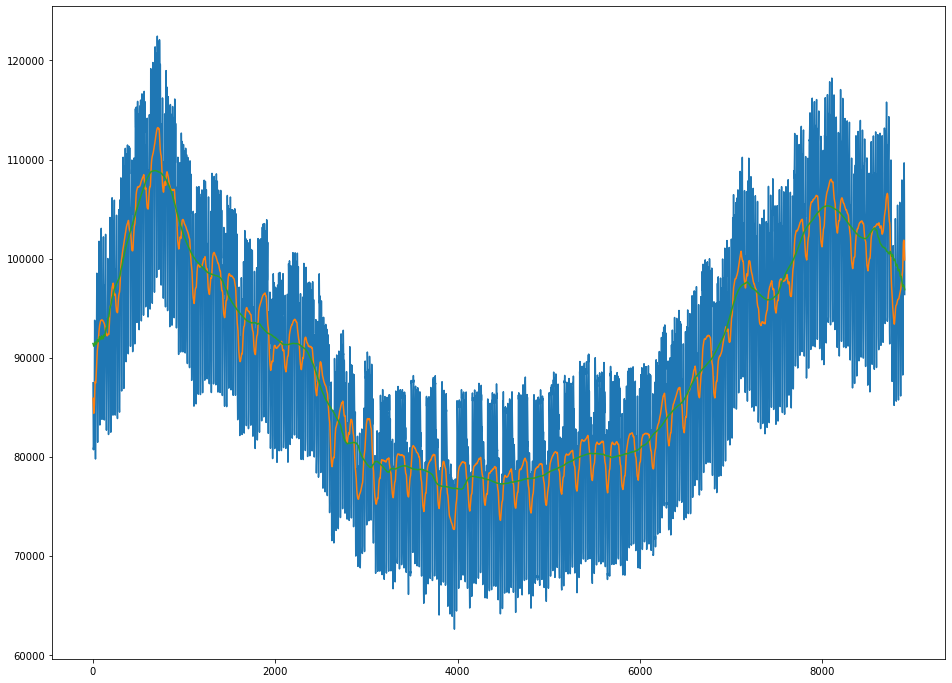

In [89]:
curve = gen_fact[:24*7*53]
plt.plot(curve)
# Удалены ежедневные тренды
plt.plot(running_mean(curve, 24))
# Убраны еженедельные трендыb
plt.plot(running_mean(curve, 24 * 7))

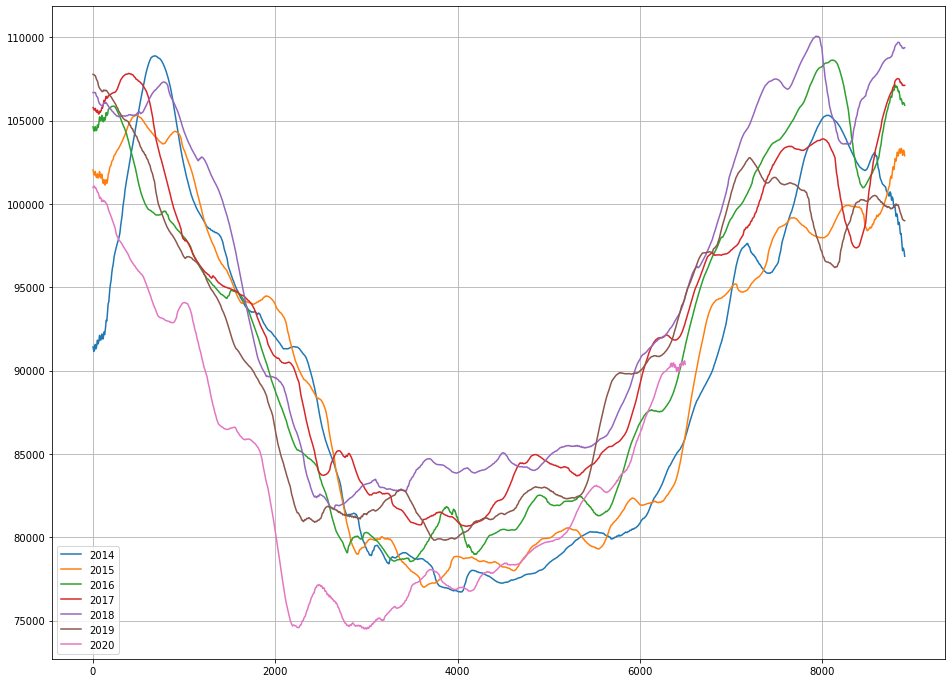

In [96]:
# Сравниваем данные по годам (разделение на годы условное, можно извлекать из датафрейма корректно)
year_step = 24 * 7 * 53
year = 2014
for i in range(7):
    curve = gen_fact[i * year_step : (i + 1) * year_step]
    # Удалены ежедневные тренды
    # plt.plot(running_mean(curve, 24))
    # Убраны еженедельные тренды
    plt.plot(running_mean(curve, 24 * 7), label='{0}'.format(year + i))
plt.grid(True)
plt.legend()